### Imports

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import geopy.distance
from folium.plugins import HeatMap

# Custom imports
import sys
sys.path.append('..')
from src.data.database import DatabaseConnector
from src.config import Config

# Plotting settings
plt.style.use('seaborn-v0_8')  # or use 'seaborn-darkgrid'
# Alternative: just use seaborn's default style
sns.set_theme()  # This sets the seaborn default style
sns.set_palette('husl')
%matplotlib inline

### Data Loading 

In [12]:
# Initialize database connector
db = DatabaseConnector()

try:
  # Get all user attributes first
  all_users = db.get_user_attributes()

  # Select the first user_id and convert to string
  user_id = str(all_users['user_id'].iloc[0])
  print(user_id)
  # Now get data for this specific user
  user_data = db.get_user_data(user_id)
  print("user_data",user_data)
  location_data = db.get_gps_fixes()
  print("location data",location_data)


  print("\nUser attributes shape:", user_data['user_attributes'].shape)
  print("Loan outcomes shape:", user_data['loan_outcomes'].shape)
  print("GPS fixes shape:", user_data['gps_fixes'].shape)

  print("\nUser attributes sample:")
  print(user_data['user_attributes'].head())

  # Print loan outcomes summary
  if not user_data['loan_outcomes'].empty:
      print("\nLoan outcomes summary:")
      print(user_data['loan_outcomes']['loan_outcome'].value_counts())
      
except Exception as e:
  print(f"An error occurred: {str(e)}")
finally:
  # Close the connection
  db.close()

2024-11-13 19:46:40,887 - src.data.database - INFO - Database connection successful
2024-11-13 19:46:41,546 - src.data.database - INFO - Retrieved 400 user attribute records


122


2024-11-13 19:46:42,082 - src.data.database - INFO - Retrieved 1 user attribute records
2024-11-13 19:46:42,627 - src.data.database - INFO - Retrieved 1 loan outcome records
2024-11-13 19:46:43,157 - src.data.database - INFO - Retrieved 38 GPS fix records


user_data {'user_attributes':    user_id  age  cash_incoming_30days age_group  income_quartile
0      122   35                  11.9     adult                1, 'loan_outcomes':    user_id      application_at loan_outcome  day_of_week  hour_of_day
0      122 2018-04-07 19:00:59    defaulted          6.0         19.0, 'gps_fixes':     user_id  accuracy  altitude  bearing          gps_fix_at  latitude  \
0       122    198.59       0.0      0.0 2018-01-23 11:31:35 -0.300596   
1       122    142.50       0.0      0.0 2018-04-07 13:33:40 -0.288306   
2       122   2300.00       0.0      0.0 2017-07-29 02:53:43 -0.292713   
3       122   3400.00       0.0      0.0 2017-08-01 10:23:19  0.184981   
4       122   3800.00       0.0      0.0 2017-09-06 18:48:30 -0.321656   
5       122   3400.00       0.0      0.0 2017-12-12 11:07:41 -0.307381   
6       122   3071.00       0.0      0.0 2017-08-02 08:41:06  0.103068   
7       122   2410.00       0.0      0.0 2018-04-07 18:39:37 -0.275824   
8 

2024-11-13 19:46:48,843 - src.data.database - INFO - Retrieved 26710 GPS fix records
2024-11-13 19:46:48,851 - src.data.database - INFO - Database connection closed


location data        user_id  accuracy  altitude  bearing          gps_fix_at  latitude  \
0            1      68.4       0.0      0.0 2017-06-22 09:37:20 -1.294342   
1            1    1409.0       0.0      0.0 2017-08-14 07:50:27 -1.341928   
2            1      68.4       0.0      0.0 2017-06-13 10:34:29 -1.307220   
3            1    1581.0       0.0      0.0 2017-06-18 12:16:20 -1.309984   
4            1    1396.0       0.0      0.0 2017-06-28 09:39:08 -1.280310   
...        ...       ...       ...      ...                 ...       ...   
26705      400    4744.0      -1.0     -1.0 2016-04-18 16:29:59 -1.298492   
26706      400    4656.0      -1.0     -1.0 2016-06-03 12:50:27 -1.298735   
26707      400    4656.0      -1.0     -1.0 2016-06-03 15:14:14 -1.314915   
26708      400    3419.0      -1.0     -1.0 2016-05-14 16:55:33 -1.260356   
26709      400    3606.0      -1.0     -1.0 2016-06-03 17:19:25 -1.290046   

       longitude location_provider    server_upload_at  uploa

### User Data Analysis


Analysis for user_attributes
--------------------------------------------------


/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


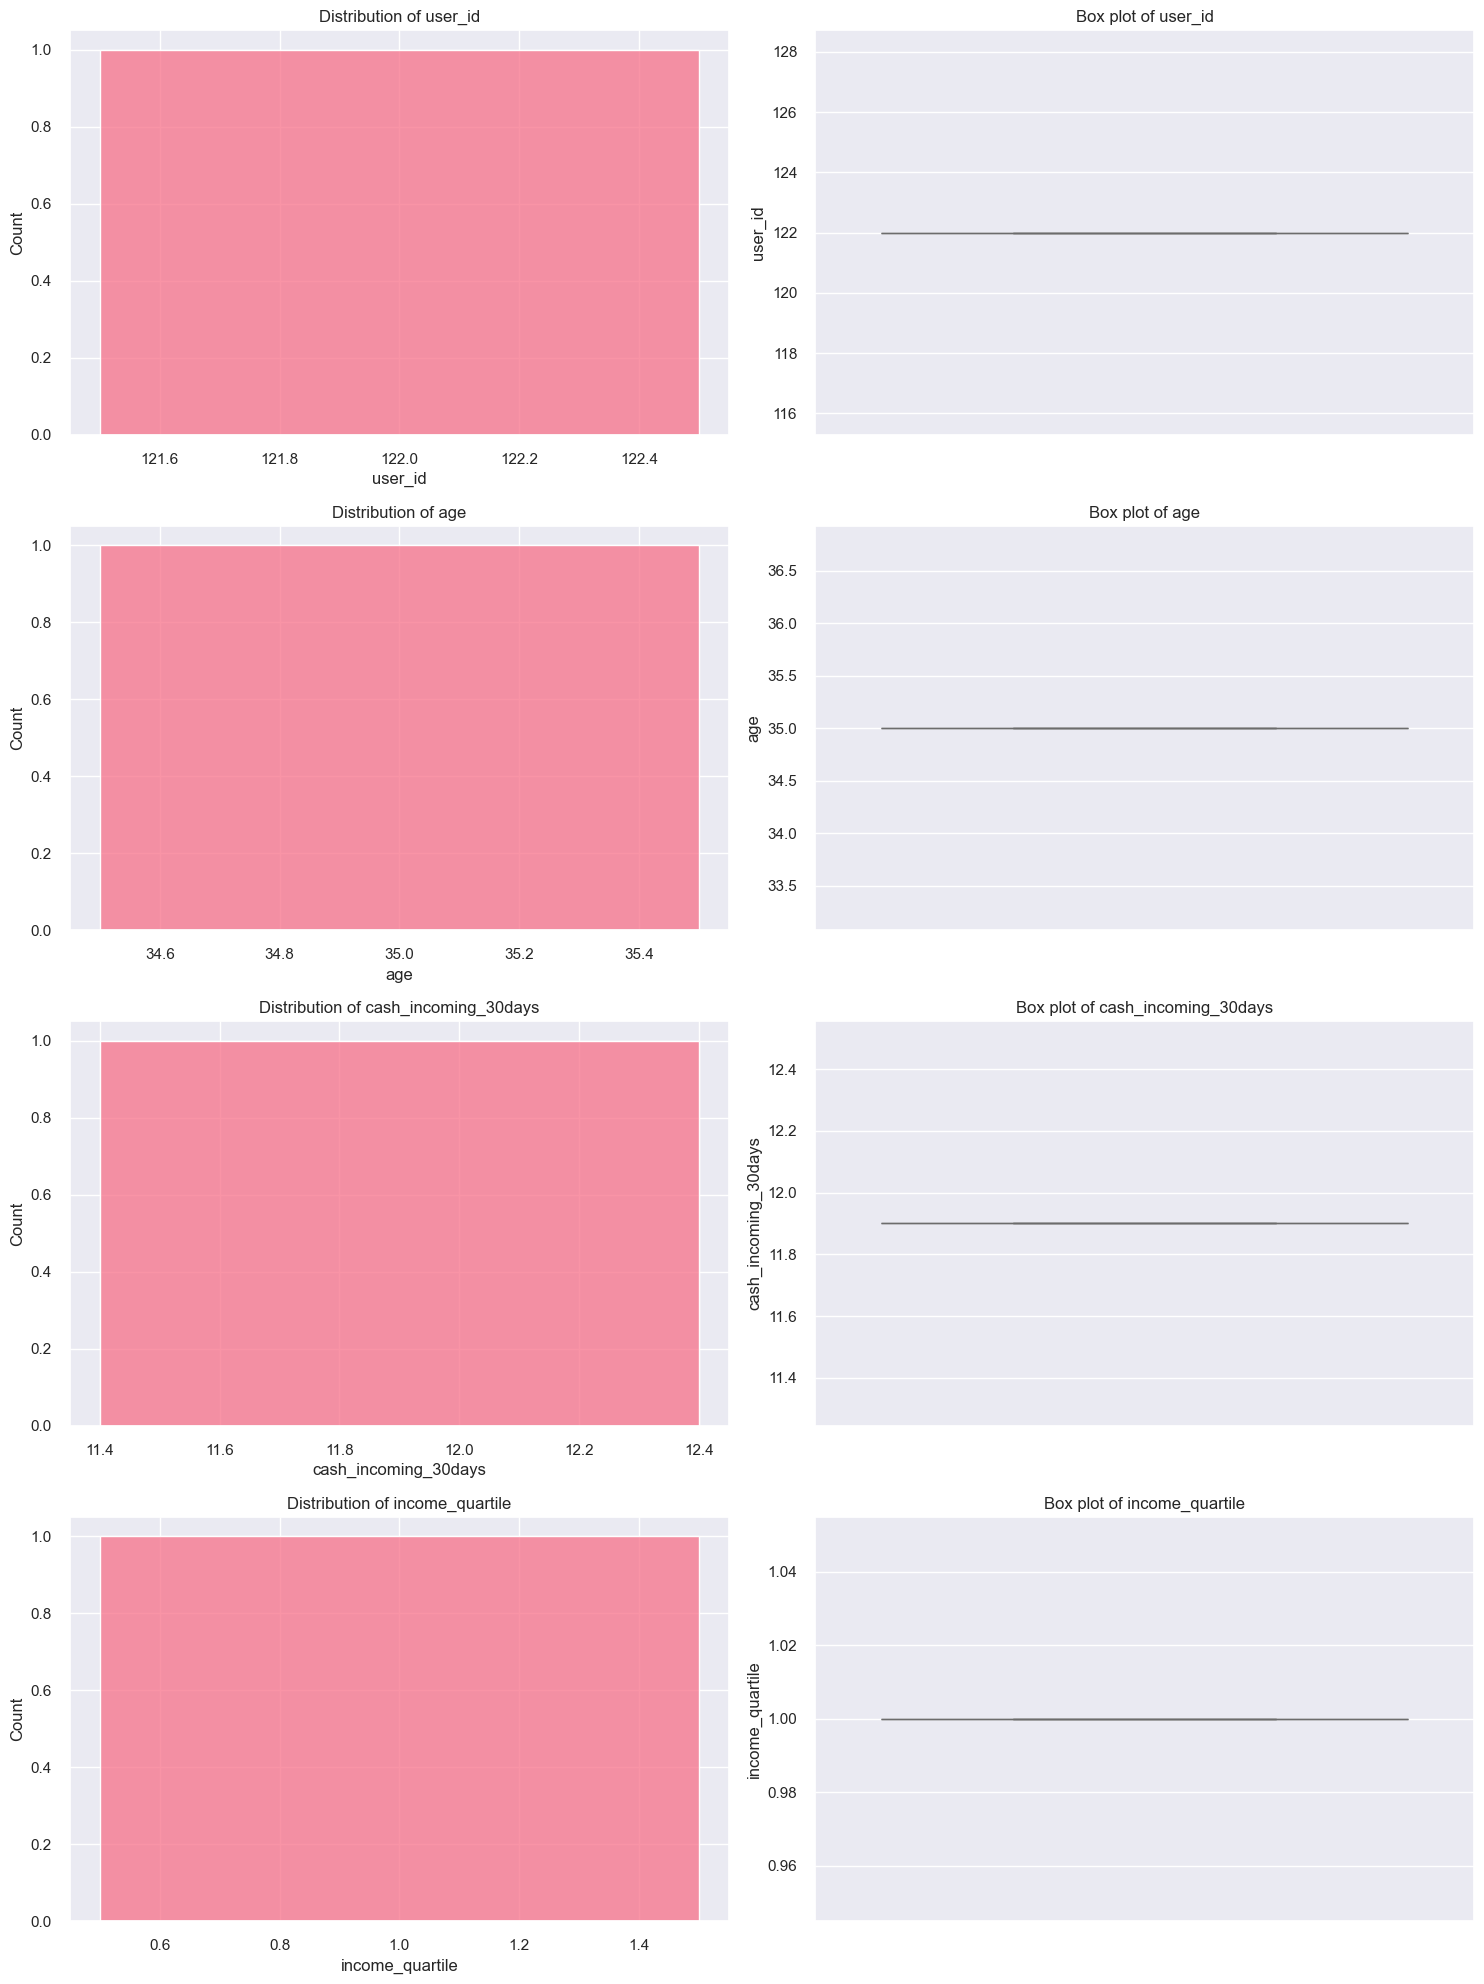

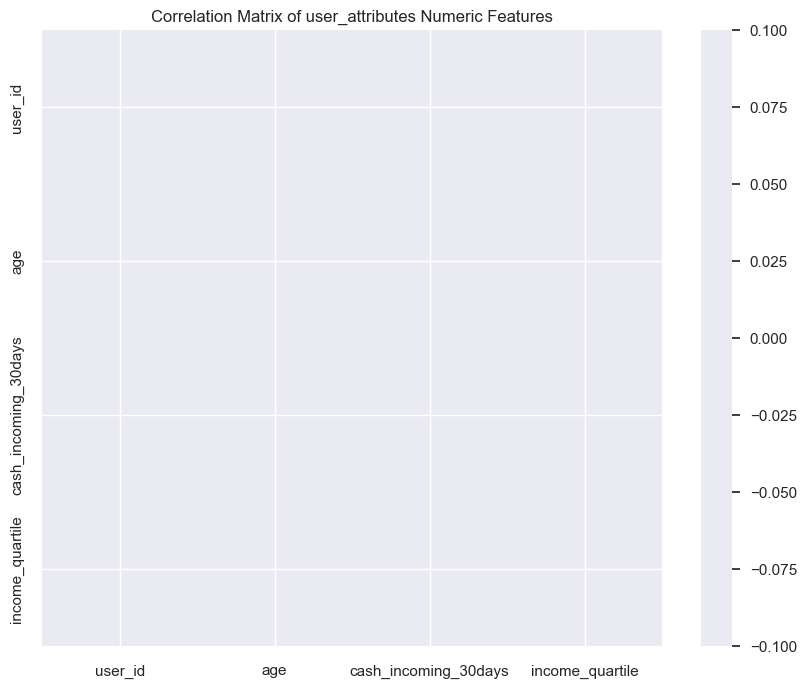


Summary Statistics:


,user_id,age,cash_incoming_30days,income_quartile
count,1.0,1.0,1.0,1.0
mean,122.0,35.0,11.9,1.0
std,NaN,NaN,NaN,NaN
min,122.0,35.0,11.9,1.0
25%,122.0,35.0,11.9,1.0
50%,122.0,35.0,11.9,1.0
75%,122.0,35.0,11.9,1.0
max,122.0,35.0,11.9,1.0



Analysis for loan_outcomes
--------------------------------------------------


/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


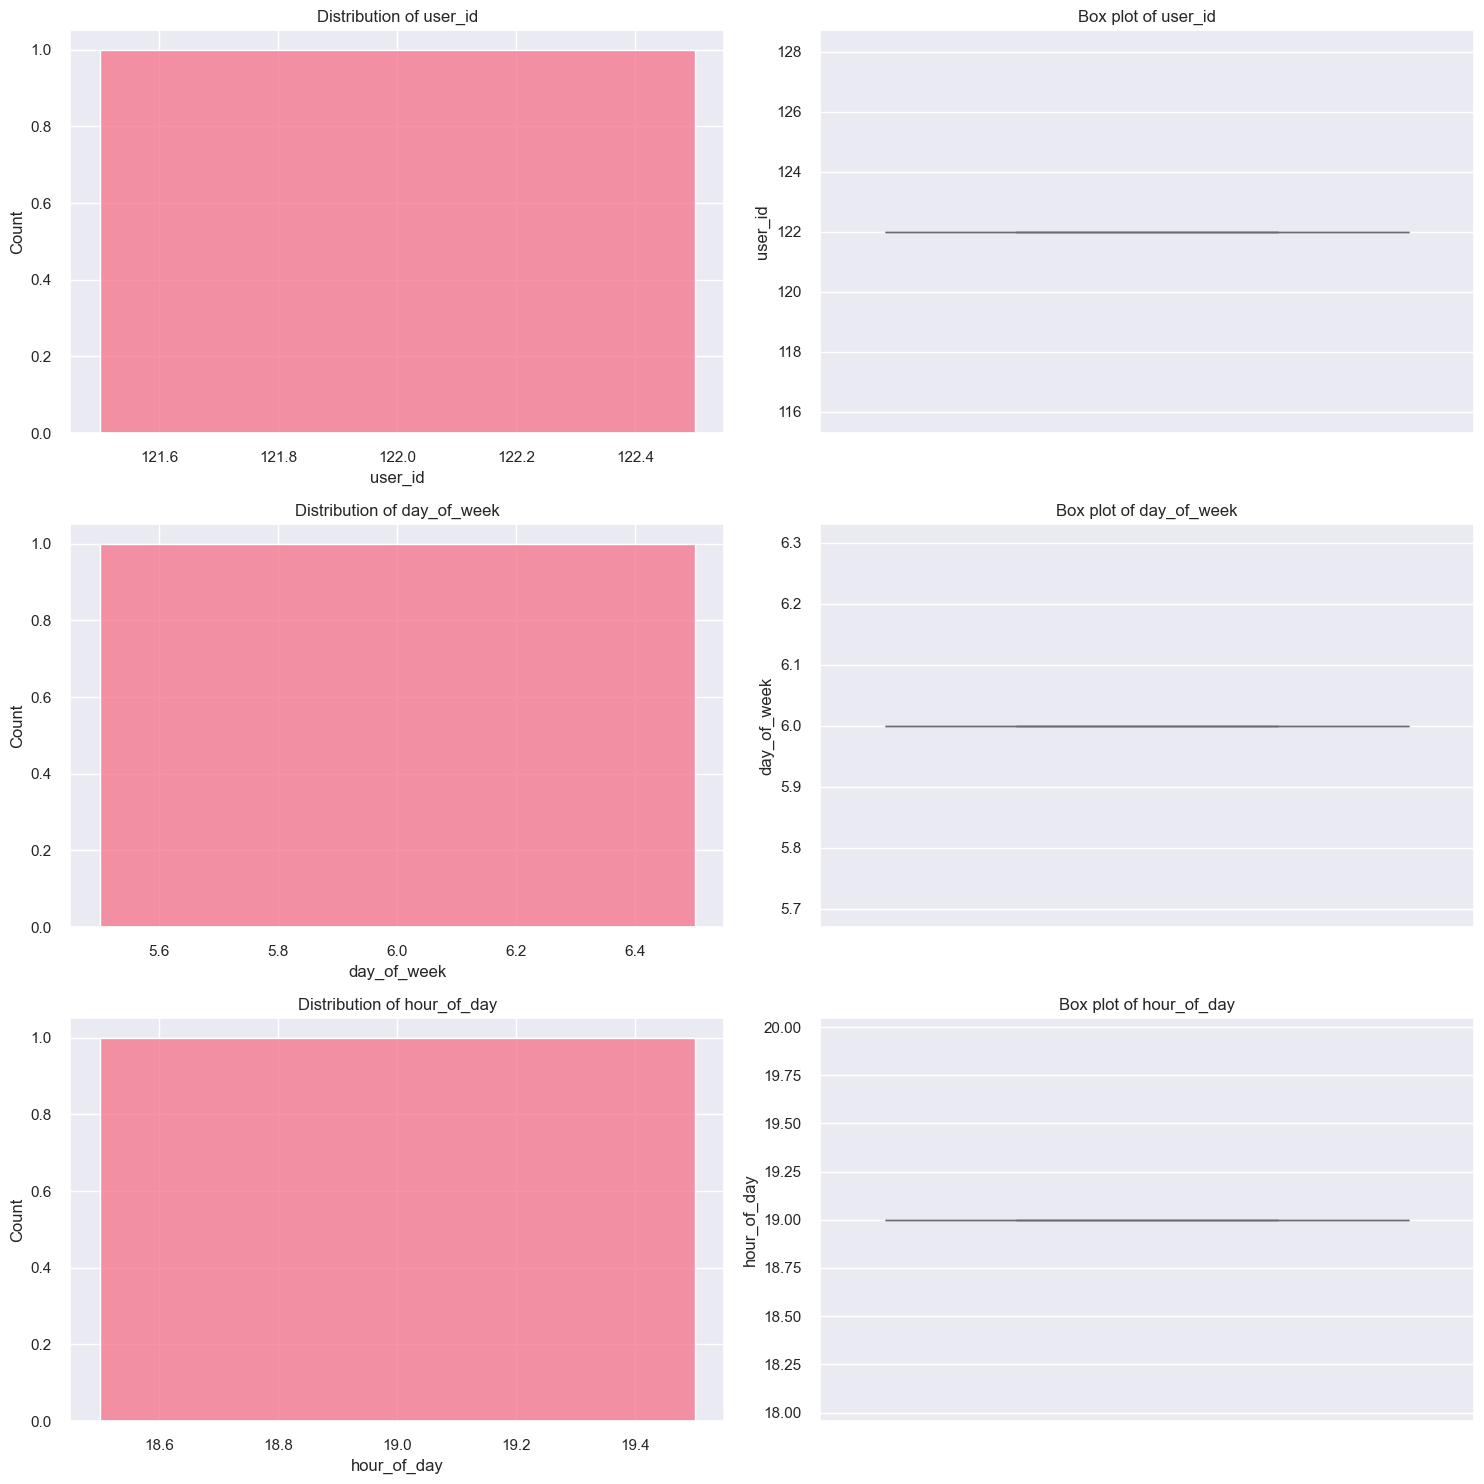

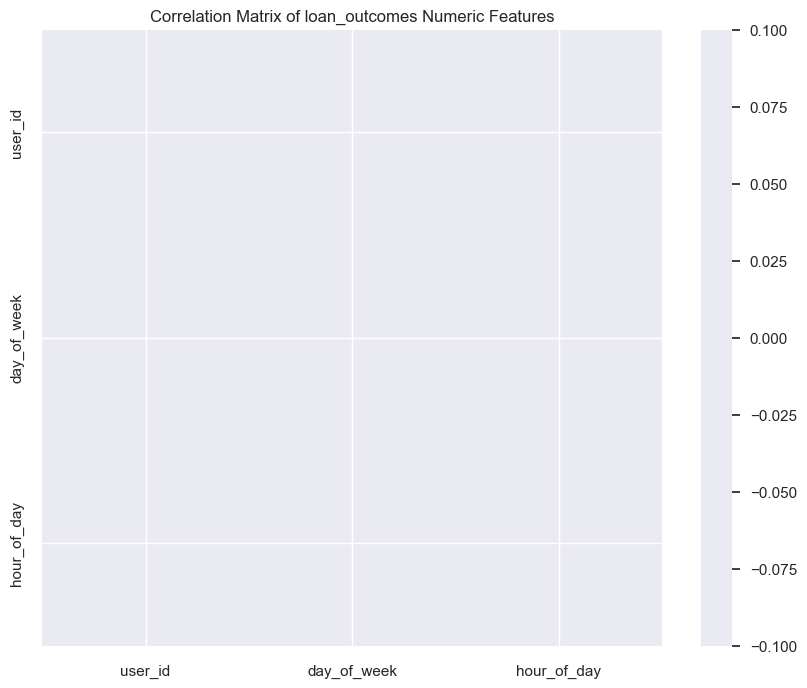


Summary Statistics:


,user_id,day_of_week,hour_of_day
count,1.0,1.0,1.0
mean,122.0,6.0,19.0
std,NaN,NaN,NaN
min,122.0,6.0,19.0
25%,122.0,6.0,19.0
50%,122.0,6.0,19.0
75%,122.0,6.0,19.0
max,122.0,6.0,19.0



Analysis for gps_fixes
--------------------------------------------------


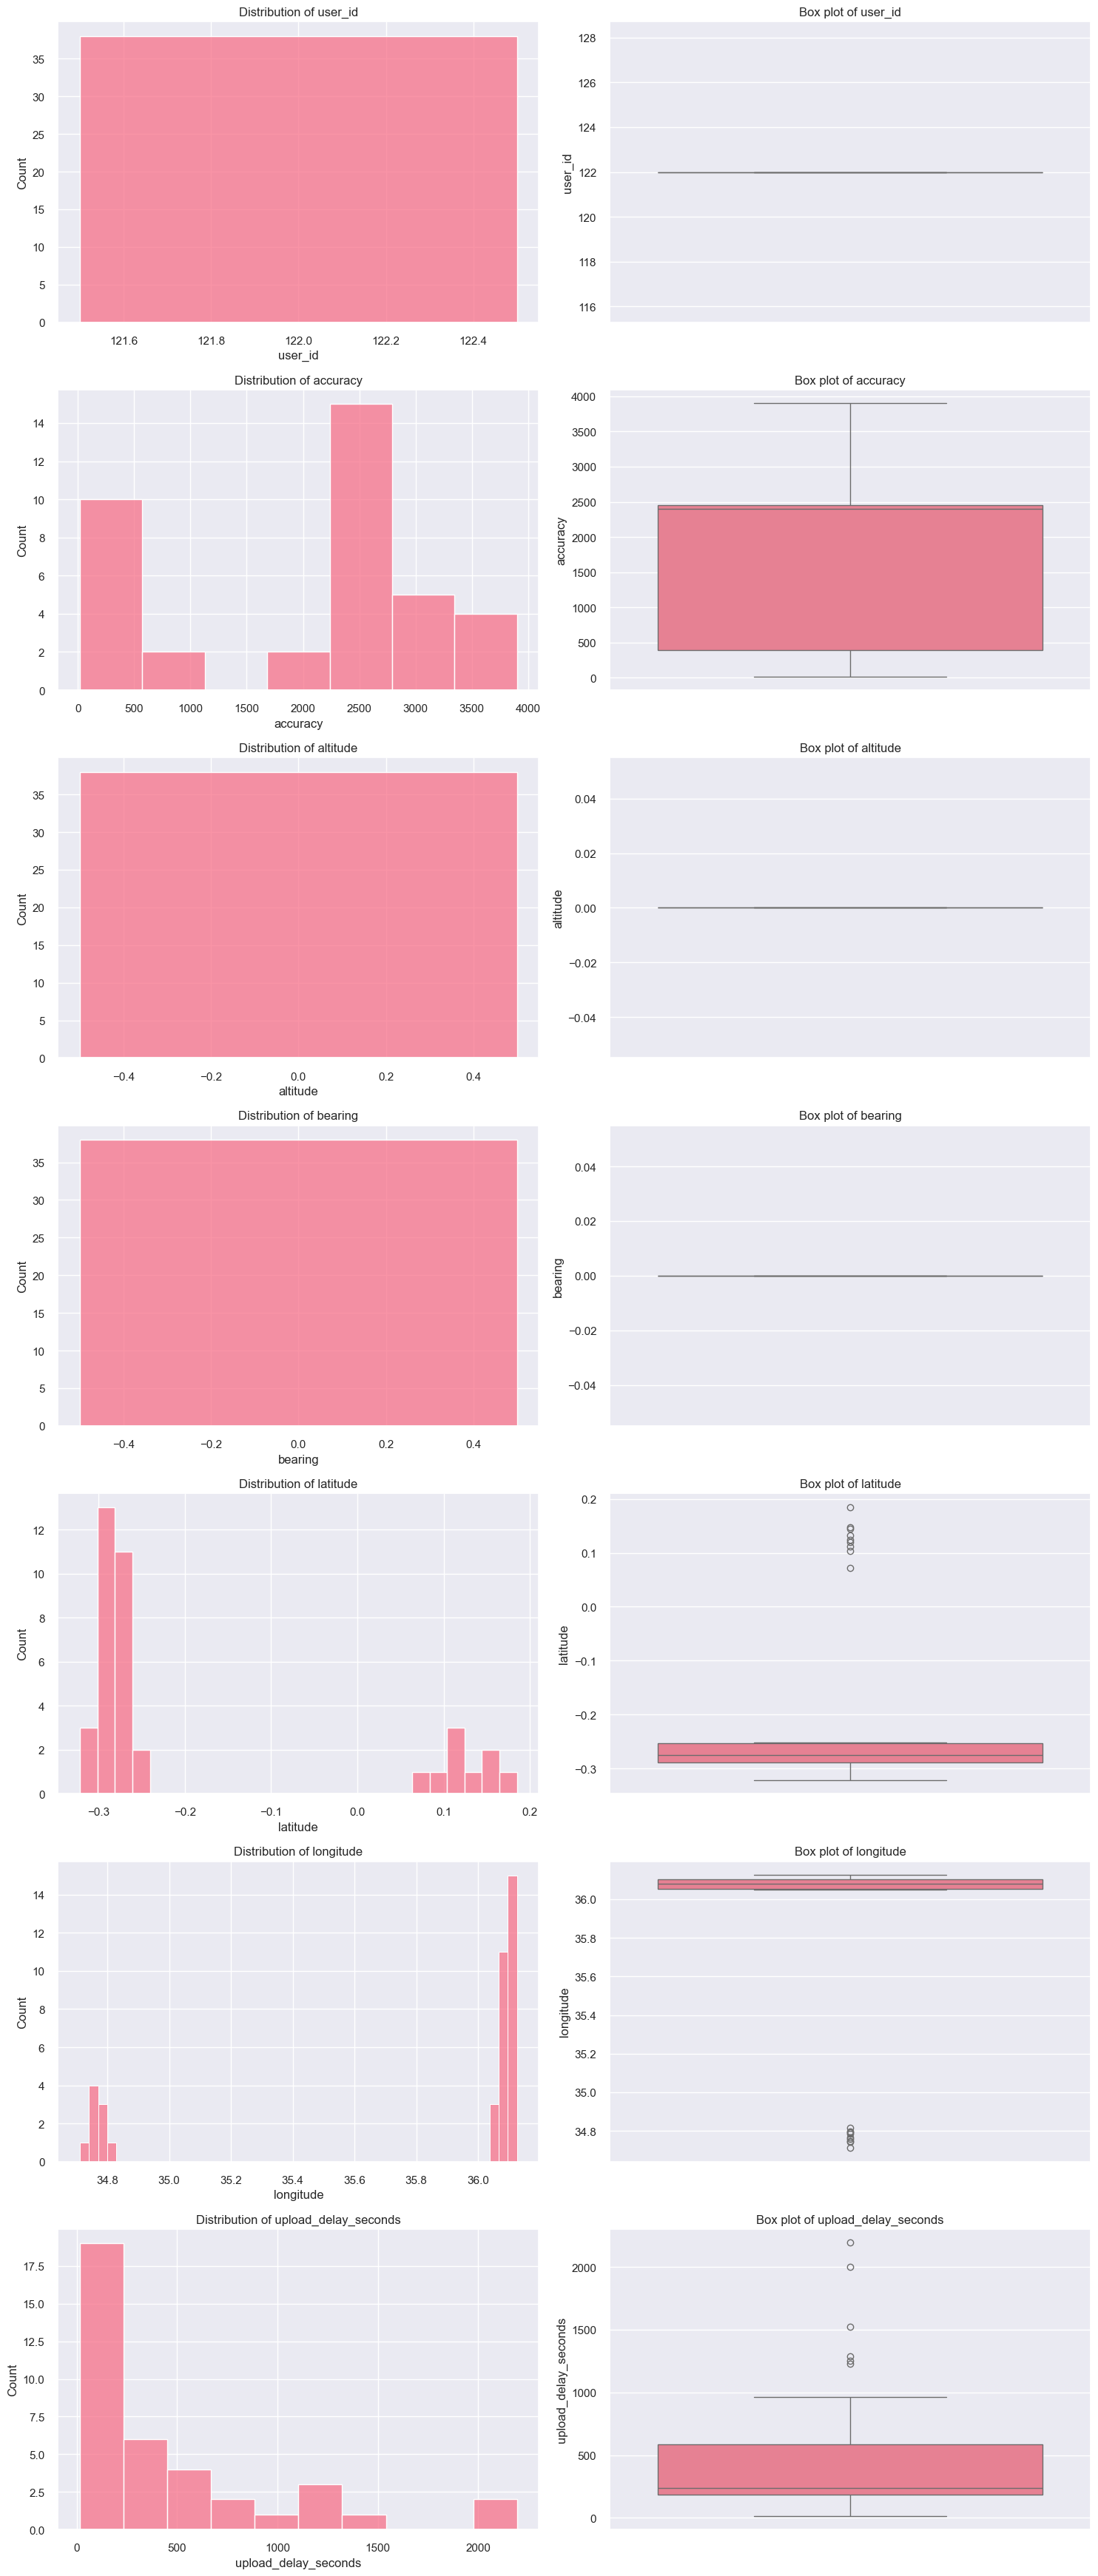

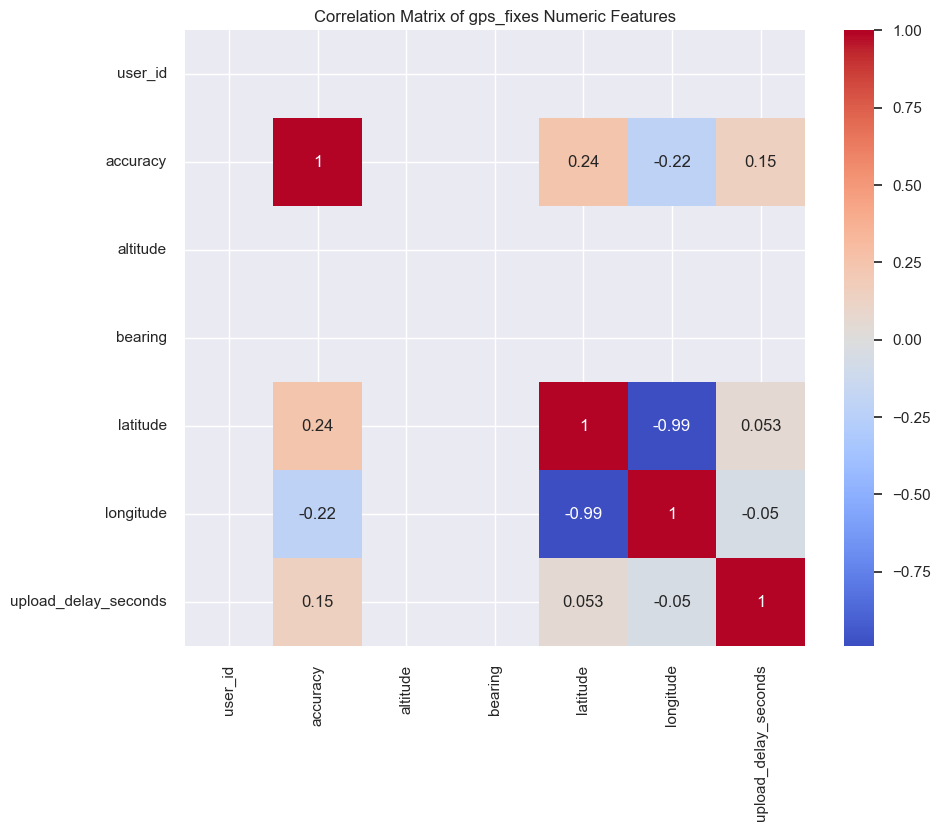


Summary Statistics:


,user_id,accuracy,altitude,bearing,latitude,longitude,upload_delay_seconds
count,38.0,38.000000,38.0,38.0,38.000000,38.000000,38.000000
mean,122.0,1905.695789,0.0,0.0,-0.184968,35.778623,504.473684
std,0.0,1257.854015,0.0,0.0,0.177114,0.570765,541.903539
min,122.0,19.020000,0.0,0.0,-0.321656,34.711026,16.000000
25%,122.0,397.867500,0.0,0.0,-0.288660,36.051544,187.500000
50%,122.0,2400.000000,0.0,0.0,-0.274753,36.081712,239.000000
75%,122.0,2457.000000,0.0,0.0,-0.253290,36.101803,588.000000
max,122.0,3900.000000,0.0,0.0,0.184981,36.126161,2193.000000


In [19]:
# Adjusted function to analyze only numeric columns in the correlation matrix
def analyze_user_data(df, name):
    print(f"\nAnalysis for {name}")
    print("-" * 50)
    
    # Numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Distribution plots
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5*len(numeric_cols)))
    for i, col in enumerate(numeric_cols):
        # Histogram
        sns.histplot(data=df, x=col, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {col}')
        
        # Box plot
        sns.boxplot(data=df, y=col, ax=axes[i, 1])
        axes[i, 1].set_title(f'Box plot of {col}')
    plt.tight_layout()
    
    # Correlation matrix for numeric data only
    if len(numeric_cols) > 1:  # Only plot if there's more than one numeric column
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Matrix of {name} Numeric Features')
        plt.show()
    
    # Summary statistics for numeric columns
    print("\nSummary Statistics:")
    display(df[numeric_cols].describe())

# Loop through each DataFrame in the user_data dictionary and analyze it
for name, df in user_data.items():
    analyze_user_data(df, name)

### Location Analysis

Location Statistics:
Total unique users: 372
Average points per user: 71.80


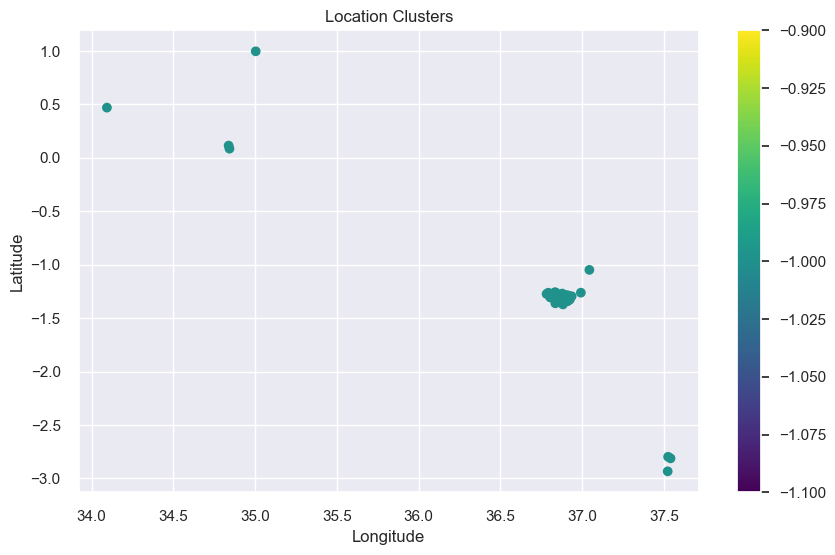

In [23]:
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def analyze_location_data(df):
    # Basic location statistics
    print("Location Statistics:")
    print(f"Total unique users: {df['user_id'].nunique()}")
    print(f"Average points per user: {len(df) / df['user_id'].nunique():.2f}")
    
    # Create map for a sample user
    sample_user_id = df['user_id'].iloc[0]
    user_locations = df[df['user_id'] == sample_user_id]
    
    # Calculate center point
    center_lat = user_locations['latitude'].mean()
    center_lon = user_locations['longitude'].mean()
    
    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add heatmap
    locations = user_locations[['latitude', 'longitude']].values.tolist()
    HeatMap(locations).add_to(m)
    
    display(m)
    
    # Cluster analysis
    coords = user_locations[['latitude', 'longitude']].values
    clustering = DBSCAN(eps=0.001, min_samples=5).fit(coords)
    
    # Plot clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(user_locations['longitude'], 
                          user_locations['latitude'],
                          c=clustering.labels_,
                          cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Location Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

analyze_location_data(location_data)


### Temporal Analysis

2024-11-13 19:57:56,318 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-13 19:57:56,331 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-13 19:57:56,371 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-13 19:57:56,381 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-13 19:57:56,

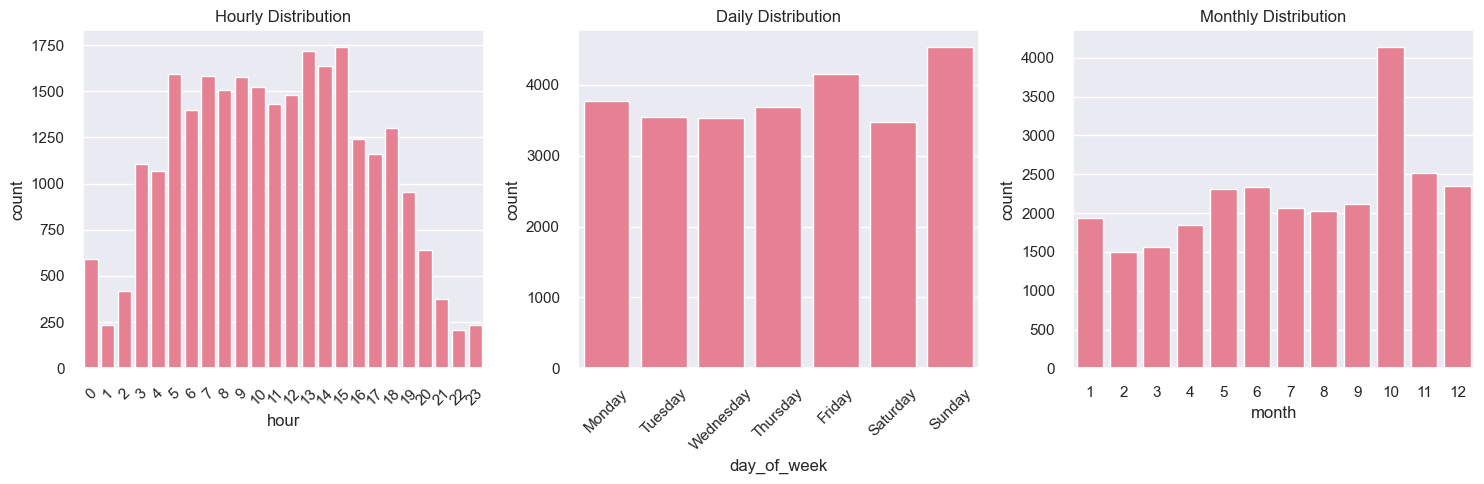


Time-based Statistics:
Most common hour: 15
Most common day: Sunday
Most common month: 10


In [25]:
def analyze_temporal_patterns(df):
  # Add time components
  df['hour'] = df['server_upload_at'].dt.hour
  df['day_of_week'] = df['server_upload_at'].dt.day_name()
  df['month'] = df['server_upload_at'].dt.month
  
  # Hourly distribution
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 3, 1)
  sns.countplot(data=df, x='hour')
  plt.title('Hourly Distribution')
  plt.xticks(rotation=45)
  
  # Daily distribution
  plt.subplot(1, 3, 2)
  sns.countplot(data=df, x='day_of_week',
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                      'Friday', 'Saturday', 'Sunday'])
  plt.title('Daily Distribution')
  plt.xticks(rotation=45)
  
  # Monthly distribution
  plt.subplot(1, 3, 3)
  sns.countplot(data=df, x='month')
  plt.title('Monthly Distribution')
  
  plt.tight_layout()
  plt.show()
  
  # Time-based metrics
  print("\nTime-based Statistics:")
  print(f"Most common hour: {df['hour'].mode().iloc[0]}")
  print(f"Most common day: {df['day_of_week'].mode().iloc[0]}")
  print(f"Most common month: {df['month'].mode().iloc[0]}")

analyze_temporal_patterns(location_data)

### Movement Analysis

/var/folders/w9/f_811bqd1p78ypmgpq95yh6w0000gn/T/ipykernel_11226/763965098.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movement_metrics = df.groupby('user_id').apply(calculate_metrics)


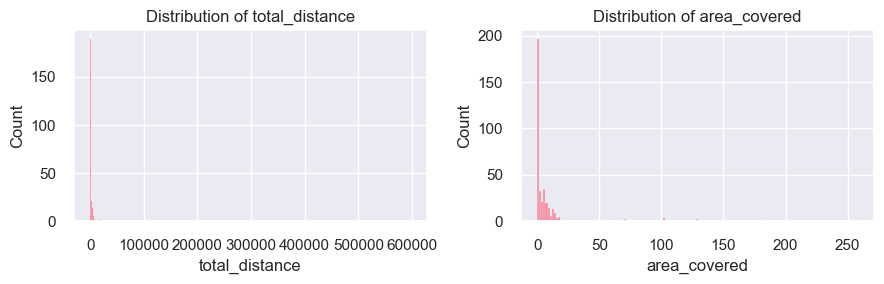

In [31]:
from scipy.spatial import ConvexHull
from geopy.distance import distance  # Import distance from geopy

def analyze_movement_patterns(df):
    def calculate_metrics(group):
        coords = group[['latitude', 'longitude']].values
        
        # Calculate distances between consecutive points
        distances = [
            distance(coords[i], coords[i + 1]).kilometers
            for i in range(len(coords) - 1)
        ]
        
        # Calculate total distance and area covered (if there are enough points)
        total_distance = sum(distances)
        area_covered = ConvexHull(coords).area if len(coords) > 3 else 0
        
        return pd.Series({
            'total_distance': total_distance,
            'area_covered': area_covered
        })
    
    # Calculate metrics per user
    movement_metrics = df.groupby('user_id').apply(calculate_metrics)
    
    # Visualize distributions of the metrics
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    for i, col in enumerate(movement_metrics.columns):
        sns.histplot(data=movement_metrics, x=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
    
    plt.tight_layout()
    plt.show()
    
    return movement_metrics

movement_metrics = analyze_movement_patterns(location_data)

### Combined Analysis

/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/omvibhandik/Desktop/branch_loan_analysis/branch_loan_analysis/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


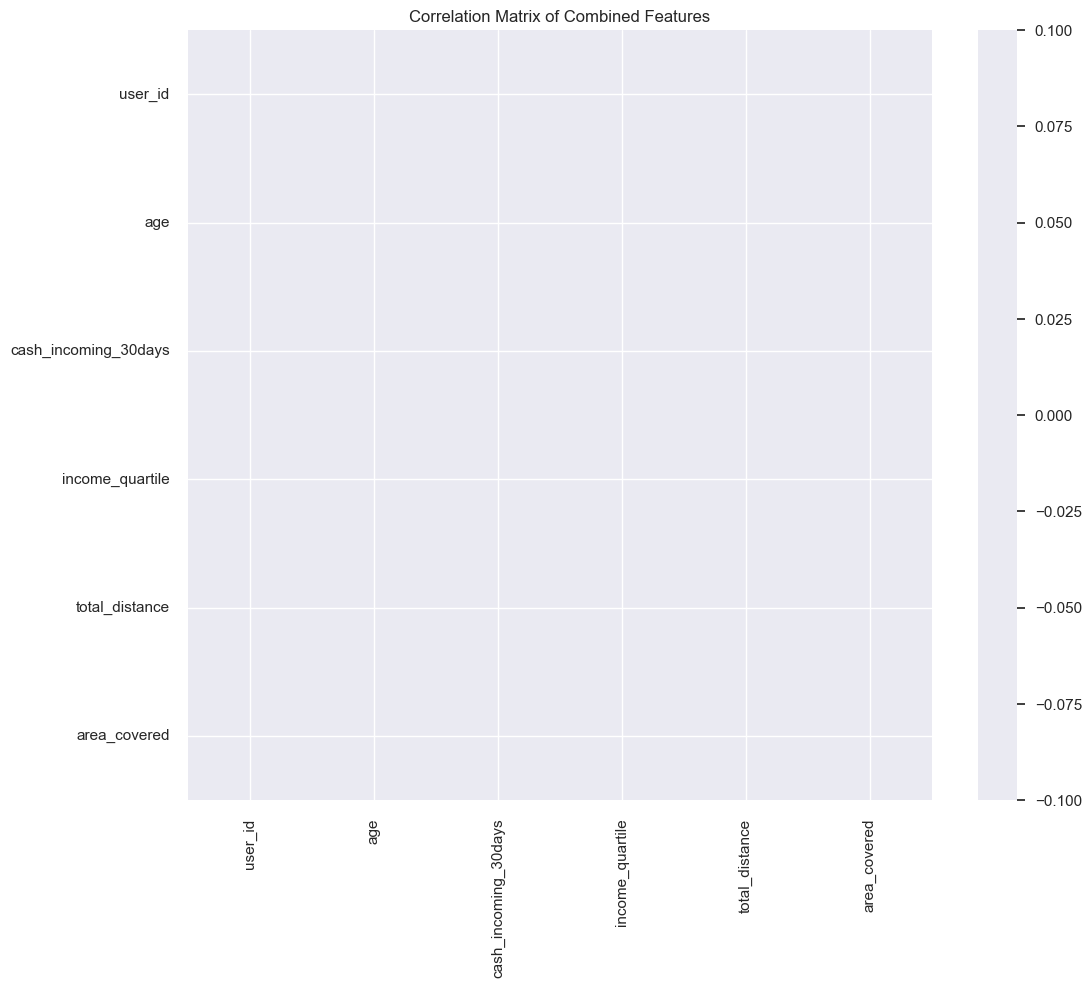

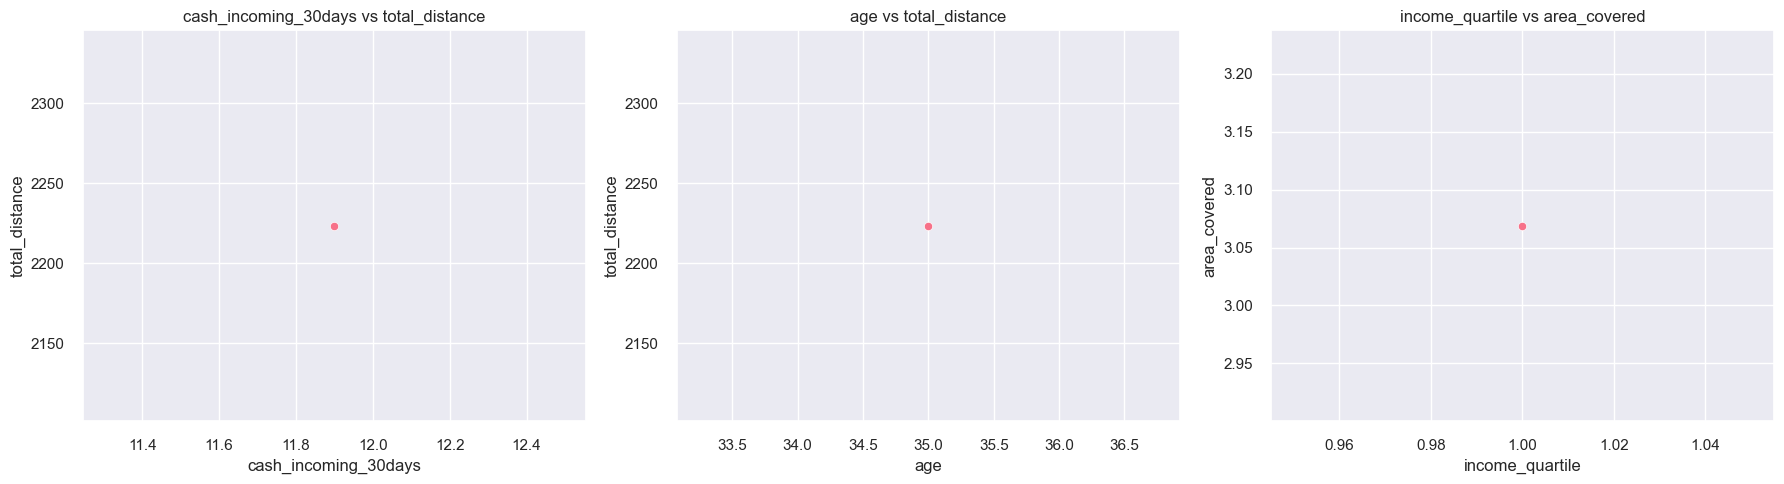

In [35]:
def analyze_combined_features(user_df, movement_metrics):
    # Use the user attributes DataFrame from user_data
    user_attributes_df = user_df['user_attributes']  # Adjust based on your actual data structure
    
    # Merge datasets
    combined_data = pd.merge(user_attributes_df, movement_metrics, 
                             left_on='user_id', right_index=True)
    
    # Filter to include only numeric columns for the correlation matrix
    numeric_data = combined_data.select_dtypes(include=[float, int])
    
    # Correlation analysis
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_data.corr(), annot=True, 
                cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Combined Features')
    plt.show()
    
    # Scatter plots for interesting relationships (only for numeric columns)
    interesting_pairs = [
        ('cash_incoming_30days', 'total_distance'),  # Adjust based on available columns
        ('age', 'total_distance'),
        ('income_quartile', 'area_covered')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (x, y) in enumerate(interesting_pairs):
        if x in numeric_data.columns and y in numeric_data.columns:  # Check if columns are numeric
            sns.scatterplot(data=combined_data, x=x, y=y, ax=axes[i])
            axes[i].set_title(f'{x} vs {y}')
    
    plt.tight_layout()
    plt.show()
    
    return combined_data

combined_data = analyze_combined_features(user_data, movement_metrics)

### Final Insights

In [38]:
def generate_insights(combined_data):
    # Filter out non-numeric columns for calculations
    numeric_data = combined_data.select_dtypes(include=[float, int])

    # Calculate insights
    insights = {
        'User Demographics': {
            'age_range': f"{combined_data['age'].min()} - {combined_data['age'].max()}",
            'income_range': f"{combined_data['cash_incoming_30days'].min():.2f} - {combined_data['cash_incoming_30days'].max():.2f}",
            'avg_income_quartile': combined_data['income_quartile'].mean()  # Adjust if needed
        },
        'Movement Patterns': {
            'avg_distance': combined_data['total_distance'].mean(),
            'avg_area': combined_data['area_covered'].mean()
        },
        'Key Correlations': {
            k: v for k, v in numeric_data.corr().get('income_quartile', {}).items()  # Ensure column exists
            if abs(v) > 0.3 and k != 'income_quartile'
        }
    }

    # Print insights
    print("Key Insights:")
    print("-" * 50)
    for category, metrics in insights.items():
        print(f"\n{category}:")
        for key, value in metrics.items():
            print(f"- {key}: {value}")

generate_insights(combined_data)

Key Insights:
--------------------------------------------------

User Demographics:
- age_range: 35 - 35
- income_range: 11.90 - 11.90
- avg_income_quartile: 1.0

Movement Patterns:
- avg_distance: 2223.4325714813754
- avg_area: 3.068817896698054

Key Correlations:
